<a href="https://colab.research.google.com/github/Krithi-B/Eye_Disease_Classification/blob/main/Eye_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eye diseases classification 2.0

*The Notebook uses 3 types of classifications -Normal eye, Cataract Eye and Conjunctivitites*



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split      # dividing the dataset
from sklearn.preprocessing import LabelEncoder            # for converting str labels to number
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sn
import random


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
import pathlib

import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.version.VERSION

'2.17.1'

# Exploratory analysis of image data

In [ ]:

def dataset_analysis(path):
    subfolders = os.listdir(path)

    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)
            format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                        image_dimensions = img.size  # (width, height)
                        image_mode = img.mode  # Mode (e.g., RGB, L)


                        # Calculate bit depth
                        if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                            bit_depth = 1
                        elif image_mode == "L":  # 8-bit pixels, grayscale
                            bit_depth = 8
                        elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                            bit_depth = 8
                        elif image_mode == "RGB":  # 8-bit pixels, true color
                            bit_depth = 24  # 8 bits per channel
                        elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                            bit_depth = 32  # 8 bits per channel
                        elif image_mode == "CMYK":  # 8-bit pixels, color separation
                            bit_depth = 32  # 8 bits per channel
                        else:
                            bit_depth = "Unknown"

                        format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

            print('--------'*10)
            print(f"Subfolder '{subfolder}' contains ({len(files)} files):")
            for format, dimensions_counts in format_dimensions_counts.items():
                print(f"- {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
                for (dimensions, bit_depth), counts in dimensions_counts.items():
                    for mode, count in counts.items():
                        print(f"  - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")



path = '/content/drive/MyDrive/Dataset'
dataset_path = path
dataset_analysis(dataset_path)


--------------------------------------------------------------------------------
Subfolder 'Cataract' contains (576 files):
- 36 images of format JPEG:
  - 1 images with dimensions (259, 194), bit depth 24, mode RGB
  - 2 images with dimensions (101, 84), bit depth 24, mode RGB
  - 7 images with dimensions (275, 183), bit depth 24, mode RGB
  - 1 images with dimensions (139, 84), bit depth 24, mode RGB
  - 2 images with dimensions (112, 84), bit depth 24, mode RGB
  - 2 images with dimensions (272, 185), bit depth 24, mode RGB
  - 1 images with dimensions (273, 185), bit depth 24, mode RGB
  - 2 images with dimensions (300, 168), bit depth 24, mode RGB
  - 1 images with dimensions (355, 142), bit depth 24, mode RGB
  - 1 images with dimensions (277, 182), bit depth 24, mode RGB
  - 1 images with dimensions (270, 187), bit depth 24, mode RGB
  - 1 images with dimensions (269, 188), bit depth 24, mode RGB
  - 1 images with dimensions (271, 186), bit depth 24, mode RGB
  - 1 images with d

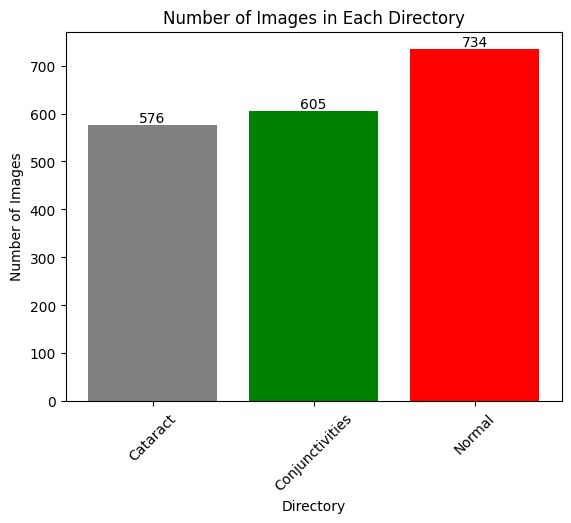

In [ ]:
# Count the number of images in each directory
subfolders = os.listdir(path)

image_counts = []
for directory in subfolders:
    sub_dir = os.path.join(path, directory)
    if os.path.isdir(sub_dir):
        file_count = len(os.listdir(sub_dir))
        image_counts.append(file_count)

#Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, image_counts[i], str(image_counts[i]), ha='center', va='bottom')

#Set some colors
colors = ['grey', 'green',  'red']

# Plotting the results
plt.bar(subfolders, image_counts, color=colors)
plt.xlabel('Directory')
plt.xticks(rotation = 45)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory')
plt.show()

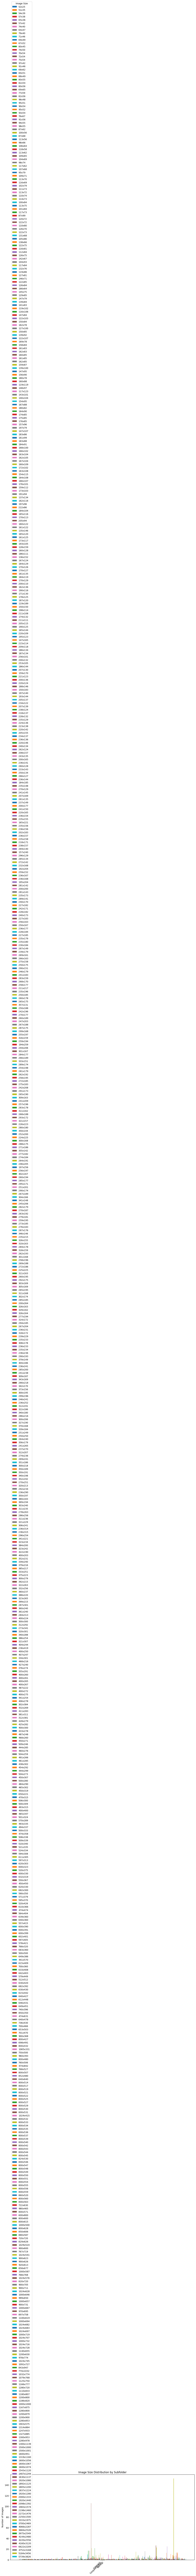

In [ ]:


def dataset_size_analysis(path):
    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        dims = img.size
                        folder_size_counts[subfolder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Create a single plot
    plt.figure(figsize=(15, 7))

    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of bars
    indices = range(len(subfolder_names))

    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar([index + i * bar_width for index in indices], counts, bar_width, label=f'{size[0]}x{size[1]}')

    plt.xticks([index + (len(all_sizes) - 1) * bar_width / 2 for index in indices], subfolder_names, rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Size Distribution by Subfolder')
    plt.legend(title="Image Size")
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)


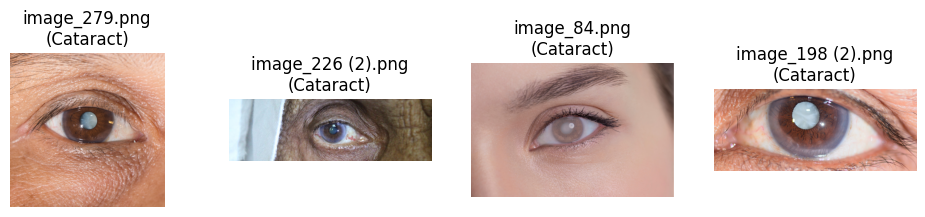

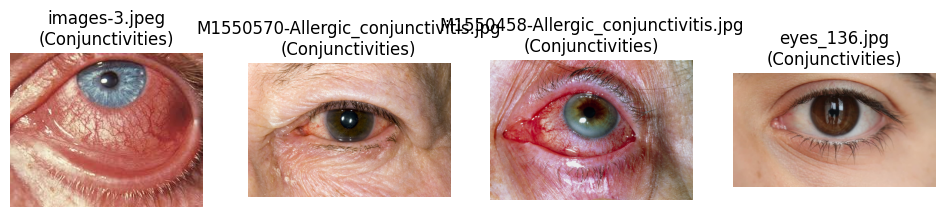

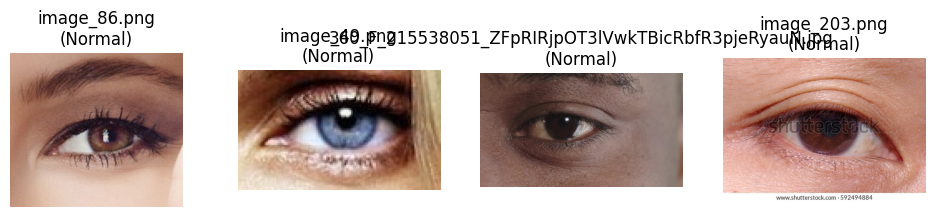

In [ ]:
# Preview photos

def random_photos_from_folders(base_folder):
    # Walk through all directories and files
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(images) >= 4:  # Ensure there are at least 4 images
            selected_images = random.sample(images, 4)  # Randomly select 4 images

            # Display selected images
            fig, axs = plt.subplots(1, 4, figsize=(12, 2))
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)
                axs[idx].imshow(img)
                axs[idx].axis('off')

                # Extract sub-folder
                subfolder_name = os.path.basename(root)
                # Set the title to include image name and sub-folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name})")

            plt.show()


random_photos_from_folders(path)

# Data preparation

In [ ]:
class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# create data path and their labeles
data = []
labels = []
extensions = ["jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "bmp", "BMP", "gif", "GIF"]

for i in class_dirs:
    class_label = i
    image_files = []
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(path, i, f"*.{ext}")))
    data.extend(image_files)
    labels.extend([class_label] * len(image_files))

if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print("Files found and listed.")


df = pd.DataFrame({
'filename': data,
'class': labels
})


df = df.sample(frac=1)

Files found and listed.


In [ ]:
display(df)

filename            class
1537  /content/drive/MyDrive/Dataset/Normal/images -...           Normal
1110  /content/drive/MyDrive/Dataset/Conjunctivities...  Conjunctivities
1666  /content/drive/MyDrive/Dataset/Normal/image_29...           Normal
838   /content/drive/MyDrive/Dataset/Conjunctivities...  Conjunctivities
611   /content/drive/MyDrive/Dataset/Conjunctivities...  Conjunctivities
...                                                 ...              ...
834   /content/drive/MyDrive/Dataset/Conjunctivities...  Conjunctivities
533   /content/drive/MyDrive/Dataset/Cataract/image_...         Cataract
767   /content/drive/MyDrive/Dataset/Conjunctivities...  Conjunctivities
1097  /content/drive/MyDrive/Dataset/Conjunctivities...  Conjunctivities
1474  /content/drive/MyDrive/Dataset/Normal/images (...           Normal

[1915 rows x 2 columns]

In [ ]:
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)

{'Cataract': 0, 'Conjunctivities': 1, 'Normal': 2}


In [ ]:
display(df)

filename  class
1537  /content/drive/MyDrive/Dataset/Normal/images -...      2
1110  /content/drive/MyDrive/Dataset/Conjunctivities...      1
1666  /content/drive/MyDrive/Dataset/Normal/image_29...      2
838   /content/drive/MyDrive/Dataset/Conjunctivities...      1
611   /content/drive/MyDrive/Dataset/Conjunctivities...      1
...                                                 ...    ...
834   /content/drive/MyDrive/Dataset/Conjunctivities...      1
533   /content/drive/MyDrive/Dataset/Cataract/image_...      0
767   /content/drive/MyDrive/Dataset/Conjunctivities...      1
1097  /content/drive/MyDrive/Dataset/Conjunctivities...      1
1474  /content/drive/MyDrive/Dataset/Normal/images (...      2

[1915 rows x 2 columns]

# Divide data into (train, validation, test)

In dividing the data into three parts, it is important to maintain the distribution ratio of the data in the original dataset. Because I want the three parts of Train + Validation + Test to have the same ratio of data and to have the same amount of data for training for each class.

In [ ]:
# Check the balance of the classes
print(df['class'].value_counts(normalize=True))
print('------'*10)

# Split the data into train+validation and test sets
train_plus_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train+validation set
train, val = train_test_split(train_plus_val, test_size=0.25, stratify=train_plus_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# train: 60%
# val: 20%
# test: 20%

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts(normalize=True))
print('------'*10)


print("Validation set:")
print(val['class'].value_counts(normalize=True))
print('------'*10)


print("Test set:")
print(test['class'].value_counts(normalize=True))

class
2    0.383290
1    0.315927
0    0.300783
Name: proportion, dtype: float64
------------------------------------------------------------
Training set:
class
2    0.382942
1    0.315927
0    0.301131
Name: proportion, dtype: float64
------------------------------------------------------------
Validation set:
class
2    0.383812
1    0.315927
0    0.300261
Name: proportion, dtype: float64
------------------------------------------------------------
Test set:
class
2    0.383812
1    0.315927
0    0.300261
Name: proportion, dtype: float64


In [ ]:
train_links, train_labels = train['filename'].values , train['class'].values
val_links , val_labels = val['filename'].values , val['class'].values
test_links, test_labels = test['filename'].values , test['class'].values

# Load and Preprocess Images

In [ ]:
# Create a Function to Load and Preprocess Images


def load_and_preprocess_image(path, label, data_augmentation=True):
    # Read the image file
    image = tf.io.read_file(path)

    # Extract file extension
    file_extension = tf.strings.split(path, '.')[-1]

    # Decode based on file extension using tf.cond
    def decode_jpeg():
        return tf.image.decode_jpeg(image, channels=3)

    def decode_png():
        return tf.image.decode_png(image, channels=3)

    def decode_bmp():
        return tf.image.decode_bmp(image, channels=3)

    def decode_gif():
        # Decode GIF and take the first frame
        return tf.squeeze(tf.image.decode_gif(image), axis=0)

    # Handle each format
    image = tf.cond(tf.math.equal(file_extension, 'jpg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'jpeg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'png'), decode_png,
            lambda: tf.cond(tf.math.equal(file_extension, 'bmp'), decode_bmp,
            lambda: tf.cond(tf.math.equal(file_extension, 'gif'), decode_gif,
            decode_jpeg)))))

    # Resize and normalize
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0, 1] range

    # Apply data augmentation if in training mode
    if data_augmentation == True:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
        image = tf.image.random_crop(image, size=[256, 256, 3])

        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label


In [ ]:

# create TensorFlow datasets for each split
# When loading datasets, pass the data_augmentation flag True or False to apply or skip augmentations:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_links , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices( (val_links , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_links , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)



In [ ]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):
    print(f"Data: {data_element.numpy()}, Label: {label_element.numpy()}")


Data: [[[ 0.721114    0.54190147  0.47252446]
  [ 0.709352    0.53013957  0.4607625 ]
  [ 0.694848    0.51563555  0.44625852]
  ...
  [ 0.5074636   0.30147725  0.2079537 ]
  [ 0.5019463   0.29752356  0.19779661]
  [ 0.4980213   0.2937945   0.19347996]]

 [[ 0.7090583   0.52752906  0.46510226]
  [ 0.70344144  0.5219123   0.45948544]
  [ 0.69680655  0.5152774   0.45285046]
  ...
  [ 0.49511743  0.28961754  0.19441342]
  [ 0.48811236  0.28581488  0.17971212]
  [ 0.48412094  0.2822109   0.1749461 ]]

 [[ 0.69502985  0.51350063  0.45107377]
  [ 0.70473903  0.5232098   0.460783  ]
  [ 0.7084619   0.5269327   0.4645058 ]
  ...
  [ 0.4964094   0.2932826   0.18987764]
  [ 0.4884367   0.28646368  0.17938772]
  [ 0.48412094  0.2822109   0.1749461 ]]

 ...

 [[-0.01911223 -0.01313734 -0.01034537]
  [-0.01911223 -0.01313734 -0.01034537]
  [-0.01911223 -0.01313734 -0.01034537]
  ...
  [-0.01911223 -0.01313734 -0.01034537]
  [-0.01911223 -0.01313734 -0.01034537]
  [-0.01911223 -0.01313734 -0.01034537

In [ ]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):
    print(f"Data: {data_element.numpy().shape}, Label: {label_element.numpy()}")


Data: (256, 256, 3), Label: 2


In [ ]:
#Datasets for model training and evaluation

batch_size = 16

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create Model

In [ ]:
model = models.Sequential([
    # First Block
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),


    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),



    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 124, 124, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 62, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 58, 58, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 29, 29, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 27, 27, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 3,533,443 (13.48 MB)

 Trainable params: 3,531,651 (13.47 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Define the EarlyStopping callback to monitor the validation accuracy
model = load_model(r'/content/drive/MyDrive/Models/Model_2.keras')

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',
    restore_best_weights=True
)


# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=r'/content/drive/MyDrive/Models/Model_2.keras',  # Path to save the model file
    monitor='val_loss',  # Change to val_loss to monitor the validation loss
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the monitored metric has minimized

)


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Fit the model
history = model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 75,
    callbacks=[early_stopping , model_checkpoint]  # Add the EarlyStopping callback
)

Epoch 1/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9309 - loss: 0.1822
Epoch 1: val_loss improved from inf to 0.64851, saving model to /content/drive/MyDrive/Models/Model_2.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 672ms/step - accuracy: 0.9309 - loss: 0.1825 - val_accuracy: 0.7441 - val_loss: 0.6485
Epoch 2/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9470 - loss: 0.1558
Epoch 2: val_loss did not improve from 0.64851
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 595ms/step - accuracy: 0.9467 - loss: 0.1563 - val_accuracy: 0.6815 - val_loss: 0.9215
Epoch 3/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9197 - loss: 0.2224
Epoch 3: val_loss did not improve from 0.64851
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 542ms/step - accuracy: 0.9196 - loss: 0.2227 - val_accuracy: 0.5509 - val_loss: 3.1786
Epoch 4/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9197 - loss: 0.2180
Epoch 4: val_loss did not improve from 0.64851
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 525ms/step - accuracy:

In [ ]:
model.save('/content/drive/MyDrive/Models/Model_2.keras')
#/content/drive/MyDrive/Colab Notebooks/model_29.keras

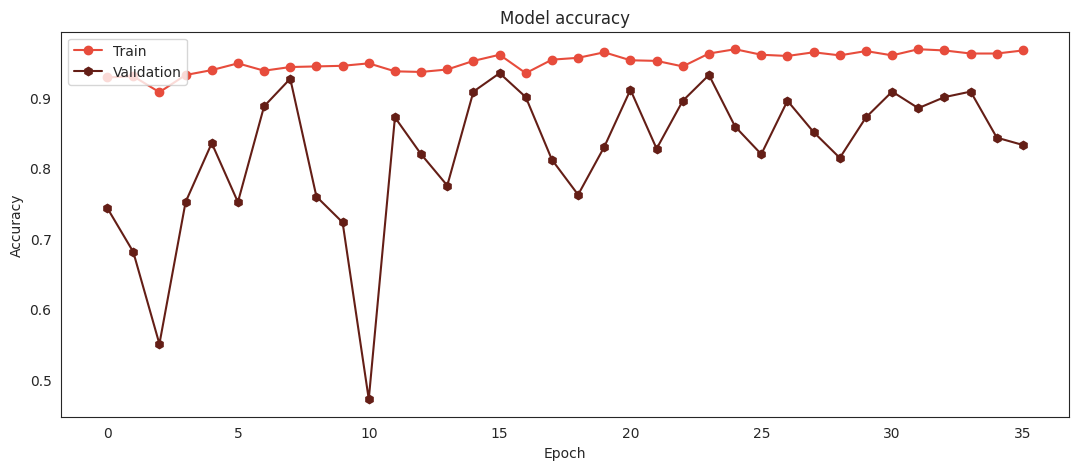

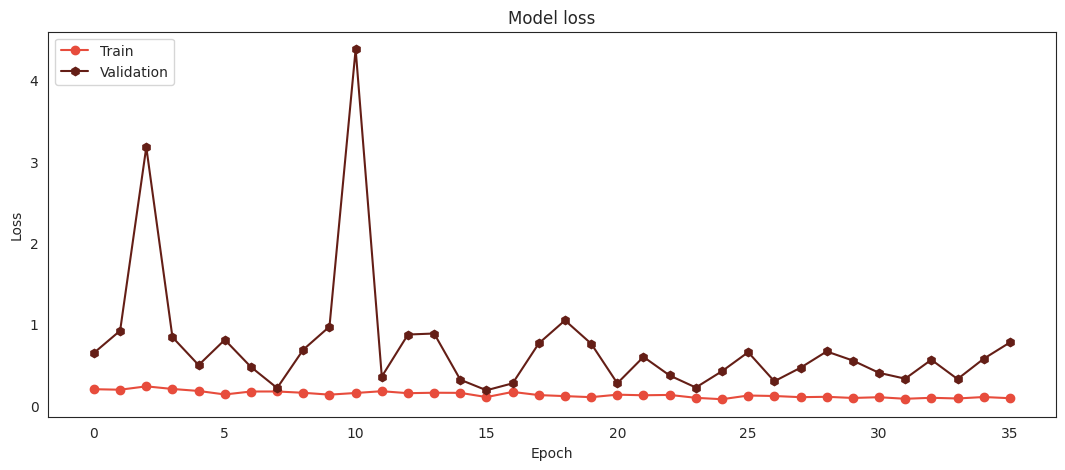

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the saved model
# If the best model is captured by the early stopping mechanism then best_model = model
# best_model = model

best_model = load_model(r'/content/drive/MyDrive/Models/Model_2.keras')



# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_dataset)
val_loss, val_accuracy = best_model.evaluate(val_dataset)
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.9161 - loss: 0.2334
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.9563 - loss: 0.1438
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.9017 - loss: 0.2265
train loss: 0.2287926971912384
train accuracy: 0.9216710329055786
------------------------
val loss: 0.18892893195152283
val accuracy: 0.934725821018219
------------------------
Test loss: 0.2003631591796875
Test accuracy: 0.9268929362297058


In [ ]:
# Assuming best_model is your trained Keras model

# Get the predicted labels from the model
y_pred = np.argmax( best_model.predict(test_dataset) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step
Confusion Matrix:
[[108   1   6]
 [  5 113   3]
 [  4   9 134]]

Classification Report:
                 precision    recall  f1-score   support

       Cataract       0.92      0.94      0.93       115
Conjunctivities       0.92      0.93      0.93       121
         Normal       0.94      0.91      0.92       147

       accuracy                           0.93       383
      macro avg       0.93      0.93      0.93       383
   weighted avg       0.93      0.93      0.93       383



Total Number Of Test data:  383


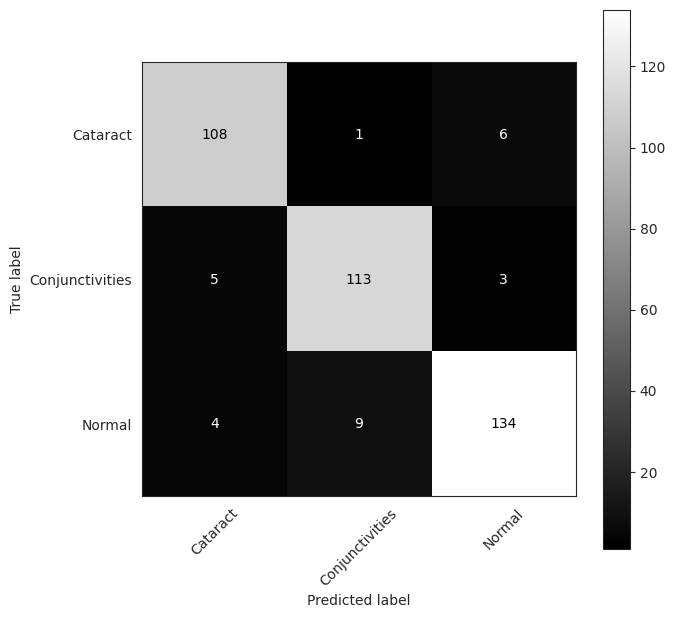

In [ ]:
#Confusion matrix
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='gray', ax=ax, xticks_rotation=45)
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


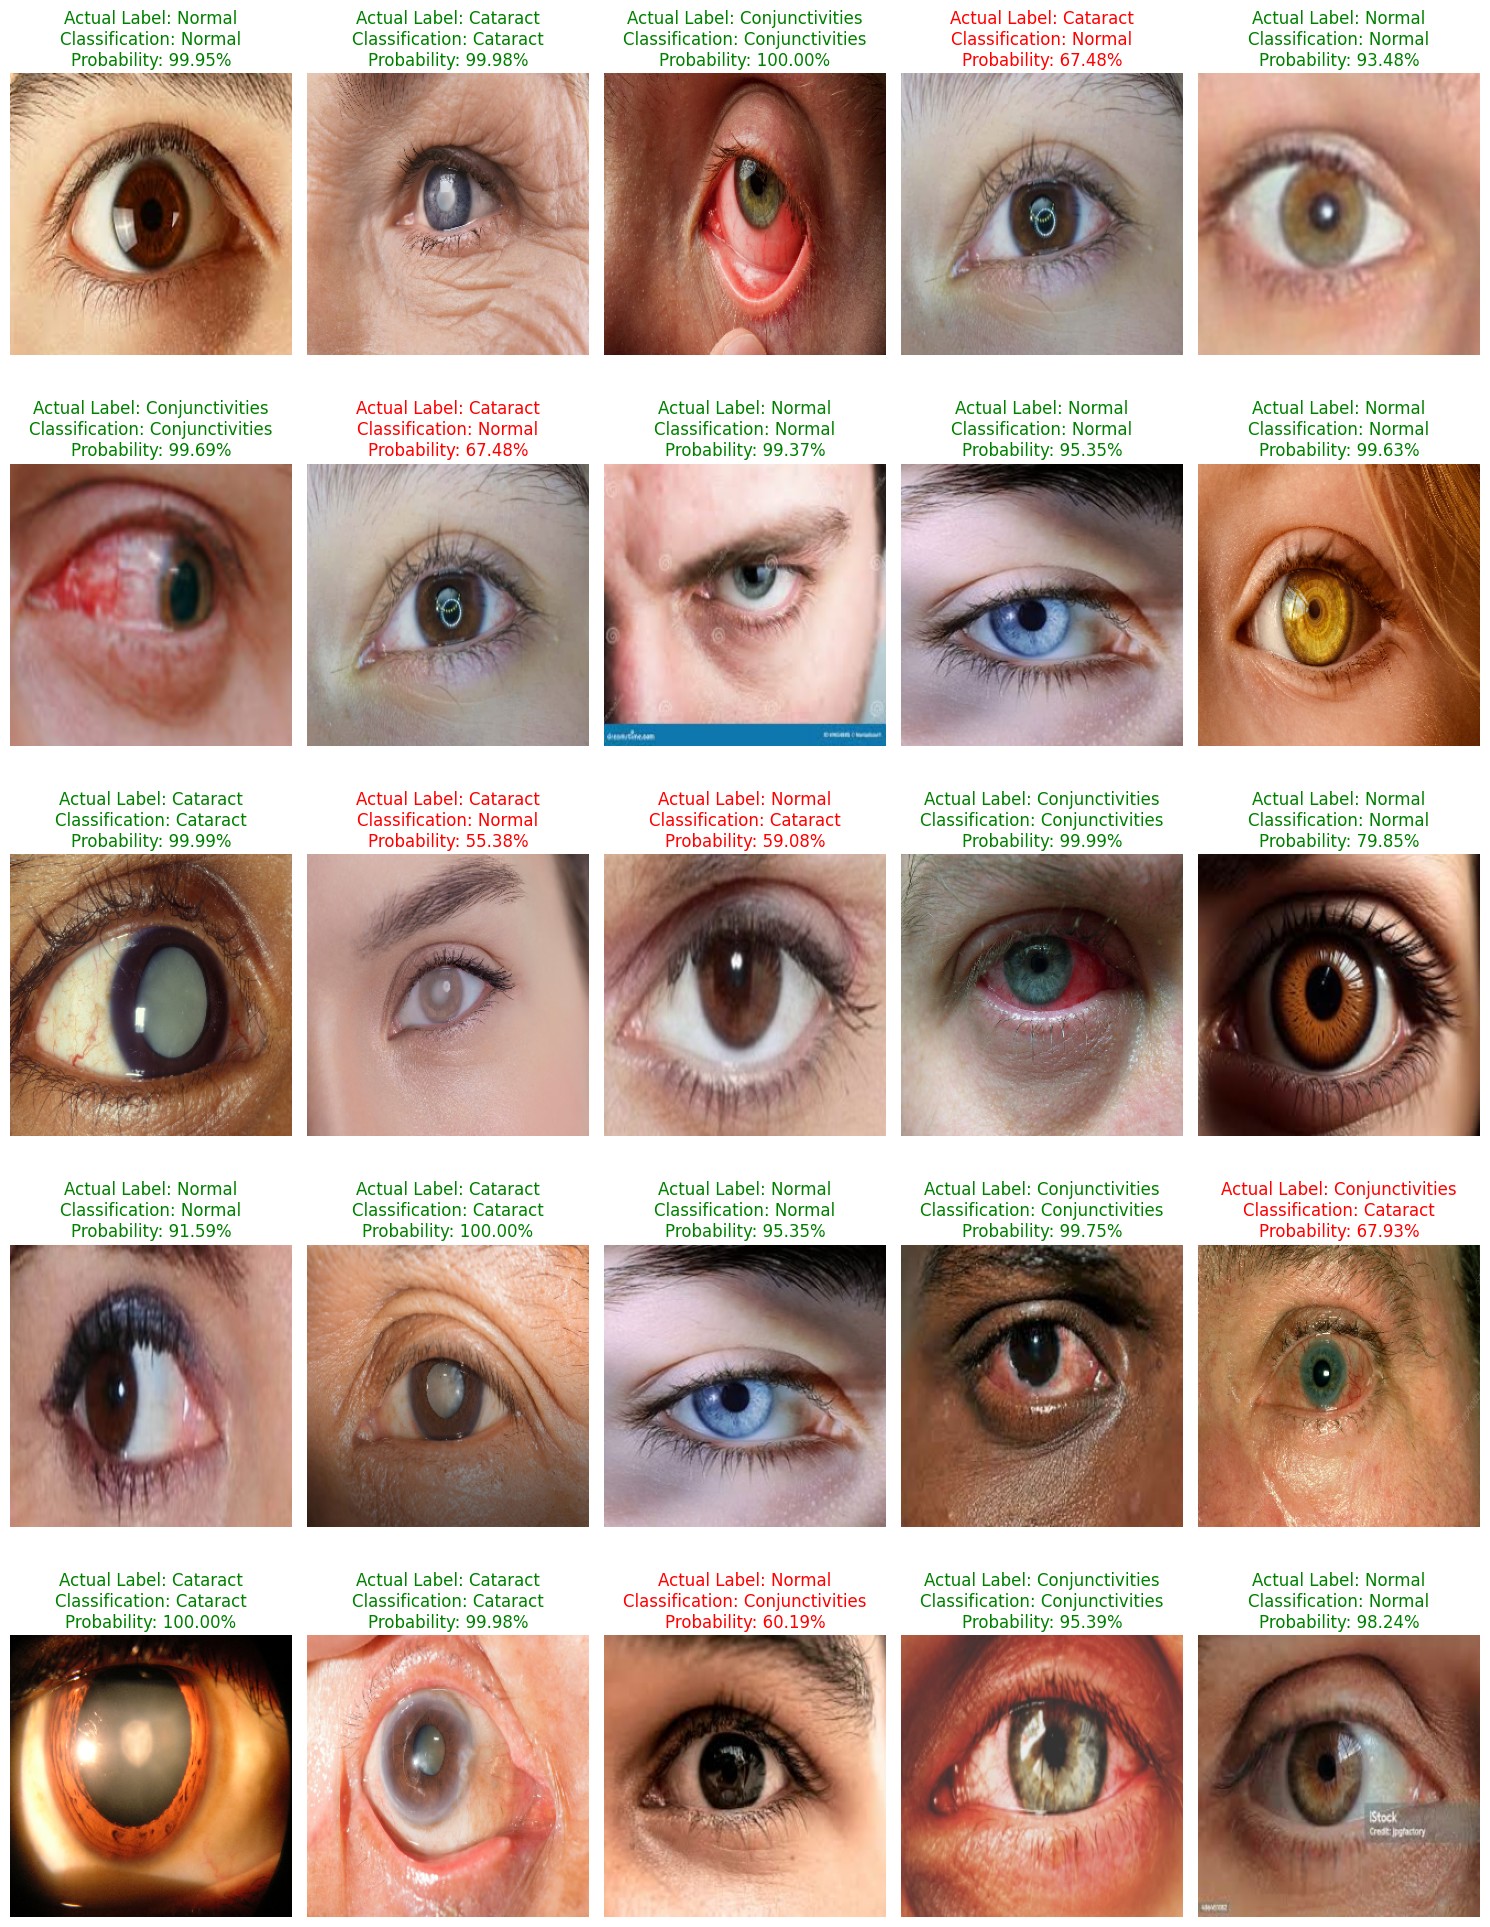

In [ ]:
# probability explanation in below function:
# For example, if the model predicts an image as class B with a probability of 0.7 (or 70%),
# the plot will show "Probability: 70%".
# This means the model is 70% confident that the image belongs to class B.


def plot_test_predictions(model, test_dataset, class_labels, num_images=25):
    """
    Plots the predictions of a model on the test dataset.

    Parameters:
    - model: Trained Keras model to be used for prediction.
    - test_dataset: TensorFlow dataset containing the test images and labels.
    - class_labels: List of class labels.
    - num_images: Number of test images to plot (default is 20).
    """

    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nClassification: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
plot_test_predictions(best_model, test_dataset, class_labels=class_names, num_images=25)

In [ ]:
(class_names)

array(['Cataract', 'Conjunctivities', 'Normal'], dtype=object)